In [1]:
import tensorflow as tf
import numpy as np
print(tf.__version__)
import matplotlib.pyplot as plt
%matplotlib inline
# mnist = tf.keras.datasets.mnist

# (x_train, y_train),(x_test, y_test) = mnist.load_data()
# x_train, x_test = x_train / 255.0, x_test / 255.0
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

1.13.1
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
tf.reset_default_graph()

batch_size = 128

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')
Y    = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='Y')
Y_flat = tf.reshape(Y, shape=[-1, 28 * 28])
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')

dec_in_channels = 1
n_latent = 100
n_sample = 1 # samples of z per minibatch

reshaped_dim = [-1, 7, 7, dec_in_channels]
inputs_decoder = 49 * dec_in_channels / 2

lambd = 2/3; zeta= 1.1; gamma=-0.1; gamma_zeta_logratio=np.log(0.1/1.1) # hyper-parameter of z

def lrelu(x, alpha=0.3):
    return tf.maximum(x, tf.multiply(x, alpha))

In [0]:
# gaussian decoder
def encoder(X_in, keep_prob, n_latent, n_sample):
    activation = lrelu
    with tf.variable_scope("encoder", reuse=None):
        X = tf.reshape(X_in, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=1, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        mn = tf.layers.dense(x, units=n_latent)
        mn_rep = tf.stack( [mn]*n_sample ) # shape = (n_sample, ?, n_latent)
        sd = 0.5 * tf.layers.dense(x, units=n_latent)    
        sd_rep = tf.stack( [sd]*n_sample )
        epsilon = tf.random_normal(tf.stack([n_sample, tf.shape(x)[0], n_latent])) # shape = (n_sample, ?, n_latent)
        z  = mn_rep + tf.multiply(epsilon, tf.exp(sd_rep))
        
        return z, mn, sd

In [0]:
def decoder(sampled_z, keep_prob):
    with tf.variable_scope("decoder", reuse=None):
        x = tf.layers.dense(sampled_z, units=inputs_decoder, activation=lrelu)
        x = tf.layers.dense(x, units=inputs_decoder * 2 , activation=lrelu)
        x = tf.reshape(x, reshaped_dim)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=28*28, activation=tf.nn.sigmoid)
        img = tf.reshape(x, shape=[-1, 28, 28])
        return img

In [0]:
def define_loss(Y_flat, dec, mn, sd):
  Y_flat = tf.keras.backend.repeat(Y_flat,n=n_sample)
  reconstruct_loss = tf.reduce_sum( tf.reduce_mean(tf.squared_difference(dec, Y_flat),axis=1), 1)
  latent_loss = tf.reduce_sum(-0.5 * (1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd)), axis=1)
  loss = tf.reduce_mean(reconstruct_loss + 1*latent_loss)
  return loss, reconstruct_loss, latent_loss

In [0]:
### build graph for vanilla-VAE

sampled, mn, sd = encoder(X_in, keep_prob, n_latent, n_sample)
print('sampled shape', sampled.shape)
decoder_temp = tf.make_template('decoder',decoder )
dec_ls = []
for i in range(n_sample):
    dec_ls.append( decoder_temp(sampled[i], keep_prob)  )
    
dec = tf.reshape( tf.transpose(tf.stack(dec_ls), [1,0,2,3]), [-1,n_sample, 28*28])
print('dec shape',dec.shape)

loss, reconstruct_loss, latent_loss = define_loss(Y_flat, dec, mn, sd)
optimizer = tf.train.AdamOptimizer(0.0005).minimize(loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
sampled shape (1, ?, 100)
Instructions for updating:
Use keras.layers.conv2d_transpose instead.
dec shape (?, 1, 784)
Instructions for updating:
Use tf.cast instead.


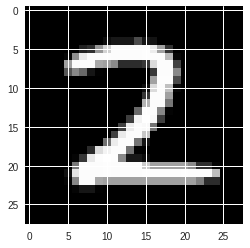

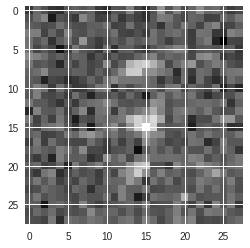

0 172.41206 172.38931 0.022760902


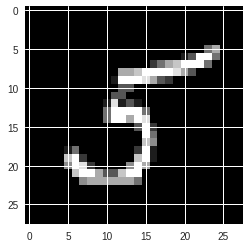

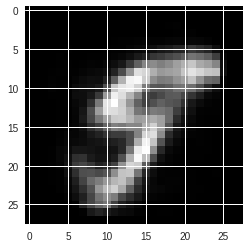

500 40.106525 33.272224 6.8342986


In [0]:
for i in range(1000):
    batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]
    sess.run(optimizer, feed_dict = {X_in: batch, Y: batch, keep_prob: 0.8})
        
    if not i % 500:
        ls, d, i_ls, d_ls, mu, sigm = sess.run([loss, dec, reconstruct_loss, latent_loss, mn, sd], feed_dict = {X_in: batch, Y: batch, keep_prob: 1.0})
        plt.imshow(np.reshape(batch[0], [28, 28]), cmap='gray')
        plt.show()
        plt.imshow(d[0,0,:].reshape([28,28]), cmap='gray')
        plt.show()
        print(i, ls, np.mean(i_ls), np.mean(d_ls))

# Sampling from the latent space

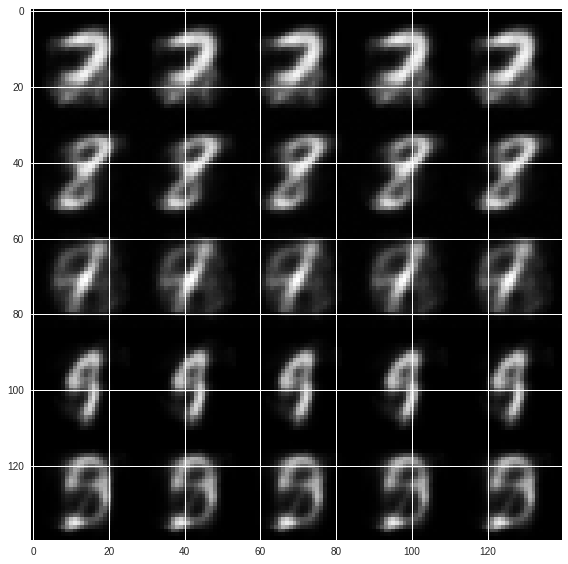

In [0]:
randoms = [[np.random.normal(0, 1, n_latent) for _ in range(25)]]
imgs = sess.run(dec, feed_dict = {sampled: randoms, keep_prob: 1.0})
imgs = [np.reshape(imgs[i], [28, 28]) for i in range(len(imgs))]


nx = ny = 5
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = imgs[i]

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

# Visualiztion of Latent Space

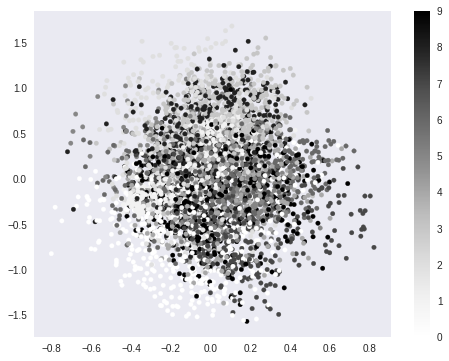

In [0]:
x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = sess.run(mn, feed_dict = {X_in: x_sample.reshape(5000,28,28), Y: x_sample.reshape(5000,28,28), keep_prob: 1.0})
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=y_sample, s=20)  # s control size of the dot
plt.colorbar()
plt.grid()

#Visualization of KL divergence

KL(q(x)||p(x)) meausres the distance between $q(x)$ and $p(x)$. Suppose $p(x)$ is the probability mass function of $Bern(\frac{1}{2})$, and $q(x)$ is the probability mass function of $Bern(q)$ Below is a visualization of the KL divergence of varying q value. It reaches 0 when q = 0.5, where p = q in this case. 

Text(0.5, 1.0, 'KL divergence')

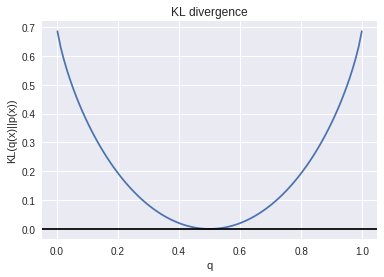

In [0]:
def KLq(q,a):
    return q*np.log(q/a) + (1-q)*np.log((1-q)/(1-a))
plt.plot(np.linspace(0.001, 0.999, 100), [ KLq( q,0.5) for q in np.linspace(0.001, 0.999, 100)])
plt.axhline(y=0, linestyle='-',color='black')
plt.ylabel(r'KL(q(x)||p(x))')
plt.xlabel('q')
plt.title('KL divergence')